In [3]:
import numpy as np
import xarray as xr
import itertools
import matplotlib.pyplot as plt
from cartopy import geodesic
import cartopy.crs as ccrs
import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import draft_functions as funk
import cmocean.cm as cmo

Comparison between simulation using two size classes $k_2$, three size classes $k_3$ or four size classes $k_4$.

In [4]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171§
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

depth_bins = np.linspace(-5500, 0, 56)  # creates a 100m bins

simulations = ['_k2', '', '_k4']
sim_names = ['k2', 'k3', 'k4']

# %% Extracting the data from simulation outputs
frag_into_NPs = {}


for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_1000{ft}.zarr'
    sim = xr.open_zarr(local_path)
    nano = sim.where(sim.radius < 1e-6/2, drop=False)
    sim_dict = {}
    print(local_path)
    
    # Find indices of the particles that are not NaN
    aux = np.isnan(nano['radius'].values)
    traj = nano.trajectory.values
    index_MP = np.sum(aux, axis=1)
    index_NP = len(nano.obs) - 1 - np.sum(aux, axis=1)
    sim_dict['particle_index'] = index_NP

    # Get depth, latitude, and longitude of NPs
    z = -nano['z'].values
    sim_dict['depths'] = z[(traj, index_NP)]

    latNP = nano['lat'].values
    lonNP = nano['lon'].values

    sim_dict['lat'] = latNP[(traj, index_NP)]
    sim_dict['lon'] = lonNP[(traj, index_NP)]

    # Compute displacement of NPs from a reference point (origin)
    xy_pos = (lonNP[(traj, index_NP)], latNP[(traj, index_NP)])
    sim_dict['displacement'] = funk.haversine(origin, xy_pos)

    # Compute histograms of particle counts for each depth bin over time
    zbins = len(depth_bins)-1
    hist_counts = np.zeros((zbins, sim_time))
    t_range = range(0, sim_time, 1)
    
    
    for i, fr in enumerate(tqdm(t_range)):
        x = np.histogram(-nano['z'][:, fr].dropna('trajectory'), bins=depth_bins,
                         density=False)
        hist_counts[:, i] = x[0]

    # Compute total number of particles in each time step
    total_particles = np.sum(hist_counts, axis=0)
    sim_dict['counts'] = total_particles

    p_zt = np.ma.masked_equal(hist_counts, 0)/total_particles
    # creat a rolling average of h_masked

    sim_dict['vertical_distribution'] = p_zt

    frag_into_NPs[sim_names[k]] = sim_dict


  0%|          | 0/3 [00:00<?, ?it/s]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_1000_k2.zarr


 33%|███▎      | 1/3 [04:57<09:54, 297.37s/it]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_1000.zarr


 67%|██████▋   | 2/3 [09:37<04:47, 287.02s/it]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_1000_k4.zarr


100%|██████████| 3/3 [14:08<00:00, 282.99s/it]


In [11]:
np.save('../data/frag_k2k3k4.npy', frag_into_NPs, allow_pickle=True)

## Plot vertical distribution

/tmp/ipykernel_407735/3886324062.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[j].pcolormesh(x, y, frag_into_NPs[ft]['vertical_distribution'],


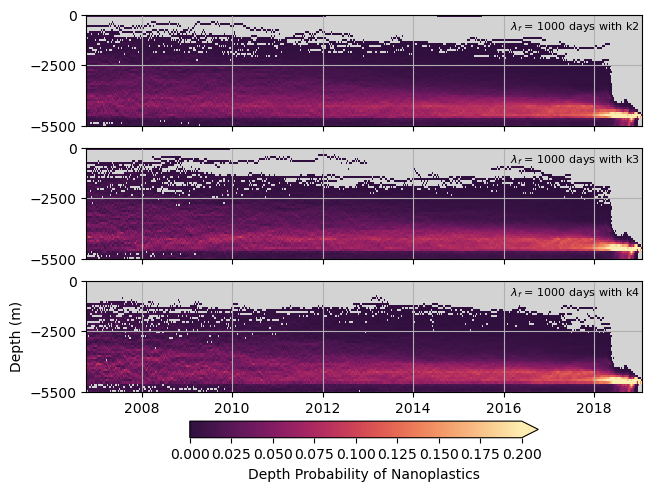

In [10]:
# %% Vertical distributions plots

x, y = np.meshgrid(datelist, depth_bins)

fig, ax = plt.subplots(ncols=1, nrows=len(simulations),
                       sharex=True, constrained_layout=True)

color_map = cmo.matter_r

for j, ft in enumerate(sim_names):
    ax[j].set_facecolor('lightgrey')
    im = ax[j].pcolormesh(x, y, frag_into_NPs[ft]['vertical_distribution'],
                          cmap=color_map,
                          vmin=0, vmax=0.2)
    ax[j].text(17900, -700, f'$\lambda_f$ = 1000 days with {sim_names[j]}', fontsize=8,
               ha='right')
    ax[j].set_yticks([-5500, -2500, 0])
    ax[j].grid()

ax[2].set_ylabel('Depth (m)')

fig.colorbar(im, ax=ax[-1], orientation='horizontal',
             extend='max', label='Depth Probability of Nanoplastics')

# ax[0].set_title('Nanoparticles (50-1000 $nm$) in the water column')
# fig.savefig('../figs/vertical_distributionsNPs.png', dpi=300,
#             facecolor=(1, 0, 0, 0))

In [13]:
sim_names

['k2', 'k3', 'k4']

# comparing non diffusive vs diffusive simulations

In [12]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171§
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

depth_bins = np.linspace(-5500, 0, 56)  # creates a 100m bins

simulations = ['400_nodiff', '400', '400_invKzdet', '0']

# %% Extracting the data from simulation outputs
diff_comparisson = {}

for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_{ft}.zarr'
    sim = xr.open_zarr(local_path)
    nano = sim.where(sim.radius < 1e-6/2, drop=False)
    sim_dict = {}
    print(local_path)
    
    # Find indices of the particles that are not NaN
    aux = np.isnan(nano['radius'].values)
    traj = nano.trajectory.values
    index_NP = len(nano.obs) - 1 - np.sum(aux, axis=1)
    sim_dict['particle_index'] = index_NP

    # Get depth, latitude, and longitude of NPs
    z = -nano['z'].values
    sim_dict['depths'] = z[(traj, index_NP)]

    latNP = nano['lat'].values
    lonNP = nano['lon'].values

    sim_dict['lat'] = latNP[(traj, index_NP)]
    sim_dict['lon'] = lonNP[(traj, index_NP)]

    # Compute displacement of NPs from a reference point (origin)
    xy_pos = (lonNP[(traj, index_NP)], latNP[(traj, index_NP)])
    sim_dict['displacement'] = funk.haversine(origin, xy_pos)

    # Compute histograms of particle counts for each depth bin over time
    zbins = len(depth_bins)-1
    hist_counts = np.zeros((zbins, sim_time))
    t_range = range(0, sim_time, 1)
    
    
    for i, fr in enumerate(tqdm(t_range)):
        x = np.histogram(-nano['z'][:, fr].dropna('trajectory'), bins=depth_bins,
                         density=False)
        hist_counts[:, i] = x[0]

    # Compute total number of particles in each time step
    total_particles = np.sum(hist_counts, axis=0)
    sim_dict['counts'] = total_particles

    p_zt = np.ma.masked_equal(hist_counts, 0)/total_particles
    # creat a rolling average of h_masked

    sim_dict['vertical_distribution'] = p_zt

    diff_comparisson[ft] = sim_dict




  0%|          | 0/4 [00:00<?, ?it/s]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_400_nodiff.zarr


 25%|██▌       | 1/4 [04:05<12:16, 245.64s/it]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_400.zarr


 50%|█████     | 2/4 [08:03<08:02, 241.34s/it]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_400_invKzdet.zarr


 75%|███████▌  | 3/4 [11:58<03:58, 238.01s/it]

/storage/shared/oceanparcels/output_data/data_Claudio/hc13_2/hc13_0.zarr


100%|██████████| 4/4 [17:04<00:00, 256.13s/it]


In [13]:
np.save('../data/diff_comparisson.npy', diff_comparisson, allow_pickle=True)